### 1.전처리
- feature: 각 이미지에 대해 HSV, LAB, RGB 평균/표준편차 통계/ 피부 채도 비율 (로우 채도 피부인지)/ 대표 RGB dominant 색상 2개
- 이미지 500 -> 2000로 늘림

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm

# 기본 설정
dataset_path = '/content/drive/MyDrive/dataset_for_capstone'
seasons = ['spring_cropped', 'summer_cropped', 'autumn_cropped', 'winter_cropped']
output_csv = '/content/drive/MyDrive/personal_color_features.csv'

In [ ]:
# HSV 기반 피부 마스크 함수
def skin_mask_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 80], dtype=np.uint8)
    upper = np.array([50, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    return mask

# Dominant color 추출 함수
def extract_dominant_color(img, mask, k=2):
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    pixels = masked_img[mask > 0]
    if len(pixels) == 0:
        return [0, 0, 0] * k
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(pixels)
    centers = kmeans.cluster_centers_.astype(int)
    return centers.flatten().tolist()

# feature 추출
def extract_features(img_or_path):
    if isinstance(img_or_path, str):
        img = cv2.imread(img_or_path)
    else:
        img = img_or_path

    if img is None:
        return None

    img = cv2.resize(img, (224, 224))
    mask = skin_mask_hsv(img)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    rgb = img

    skin_indices = np.where(mask > 0)

    if len(skin_indices[0]) < 50:
        return None

    def channel_stats(channel):
        values = channel[skin_indices]
        return np.mean(values), np.std(values)

    # HSV
    mean_H, std_H = channel_stats(hsv[:, :, 0])
    mean_S, std_S = channel_stats(hsv[:, :, 1])
    mean_V, std_V = channel_stats(hsv[:, :, 2])
    # LAB
    mean_L, std_L = channel_stats(lab[:, :, 0])
    mean_a, std_a = channel_stats(lab[:, :, 1])
    mean_b, std_b = channel_stats(lab[:, :, 2])
    # RGB
    mean_R, std_R = channel_stats(rgb[:, :, 2])
    mean_G, std_G = channel_stats(rgb[:, :, 1])
    mean_B, std_B = channel_stats(rgb[:, :, 0])

    S_vals = hsv[:, :, 1][skin_indices]
    low_s_ratio = np.sum(S_vals < 40) / len(S_vals)

    dom_colors = extract_dominant_color(img, mask, k=2)

    return [
        mean_H, std_H, mean_S, std_S, mean_V, std_V,
        mean_L, std_L, mean_a, std_a, mean_b, std_b,
        mean_R, std_R, mean_G, std_G, mean_B, std_B,
        low_s_ratio, *dom_colors
    ]


In [ ]:
# 전체 반복
results = []
for season in seasons:
    folder = os.path.join(dataset_path, f"{season}")
    for fname in tqdm(os.listdir(folder), desc=season):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        fpath = os.path.join(folder, fname)
        features = extract_features(fpath)
        if features:
            results.append([fname, season] + features)

winter_cropped: 100%|██████████| 499/499 [00:27<00:00, 18.03it/s]


In [ ]:
columns = ['image_name', 'season',
           'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V',
           'mean_L', 'std_L', 'mean_a', 'std_a', 'mean_b', 'std_b',
           'mean_R', 'std_R', 'mean_G', 'std_G', 'mean_B', 'std_B',
           'low_s_ratio',
           'dom1_R', 'dom1_G', 'dom1_B', 'dom2_R', 'dom2_G', 'dom2_B']

# CSV 저장
df = pd.DataFrame(results, columns=columns)
df.to_csv(output_csv, index=False)
print(f"✅ Feature CSV saved to: {output_csv}")

✅ Feature CSV saved to: /content/drive/MyDrive/personal_color_features.csv


### 2. 모델 학습 (MLP 기반 다중 클래스 분류)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# 1. CSV 불러오기
csv_path = '/content/drive/MyDrive/personal_color_features.csv'
data = pd.read_csv(csv_path)

# 2. feature, 라벨 지정
# season 컬럼을 label로 사용 (문자열)
X = data.drop(columns=['image_name', 'season'])  # 통계 feature 전체 (20개 이상)
y_labels = data['season']

# 3. 라벨 인코딩 및 원-핫 변환
le = LabelEncoder()
y_int = le.fit_transform(y_labels)  # 0~3 숫자 라벨로 변환
y = to_categorical(y_int)           # 원-핫 인코딩

# 4. 스케일링 (feature마다 값 범위 달라서 꼭 해야함)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. CNN 입력에 맞게 reshape (samples, timesteps, features)
# 여기서 timesteps=feature 개수, channels=1 로 변환
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 6. train/val split
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=y_int)

In [ ]:
# 7. CNN 모델 구성
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_cnn.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 계절 4개
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       172,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,316 (770.77 KB)

 Trainable params: 197,316 (770.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8. 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3006 - loss: 1.3827 - val_accuracy: 0.2839 - val_loss: 1.3841
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3197 - loss: 1.3564 - val_accuracy: 0.2613 - val_loss: 1.3869
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3370 - loss: 1.3228 - val_accuracy: 0.2915 - val_loss: 1.3766
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3690 - loss: 1.3279 - val_accuracy: 0.2839 - val_loss: 1.3822
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3908 - loss: 1.3154 - val_accuracy: 0.3116 - val_loss: 1.3892
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3805 - loss: 1.3004 - val_accuracy: 0.2739 - val_loss: 1.3985
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3618 - loss: 1.3075 - val_accuracy: 0.3166 - val_loss: 1.3937
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4162 - loss: 1.2805 - val_accuracy: 0.2940 - v

### 3. 모델 테스트

In [ ]:
import cv2
import numpy as np
import joblib  # scaler 저장/로드용
from tensorflow.keras.models import load_model


# OpenCV에서 제공하는 Haar Cascade 얼굴 검출기 로드
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face_opencv(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("얼굴이 검출되지 않았습니다.")
        return None

    # 여러 개가 검출되면 첫 번째 얼굴만 크롭
    (x, y, w, h) = faces[0]

    # 얼굴 영역 크롭 (이미지 범위 넘어가지 않도록 조정)
    x, y = max(0, x), max(0, y)
    w = min(img.shape[1] - x, w)
    h = min(img.shape[0] - y, h)

    face_img = img[y:y+h, x:x+w]
    return face_img

# 모델과 스케일러 로드
model = load_model('/content/drive/MyDrive/your_saved_model.h5')
scaler = joblib.load('/content/drive/MyDrive/your_saved_scaler.pkl')

def extract_features_from_face(face_img):
    face_img = cv2.resize(face_img, (224, 224))
    features = extract_features(face_img)  # 이미 리스트 형태의 feature 반환
    return features


def predict_season_from_image(img_path, model, scaler):
    img = cv2.imread(img_path)
    if img is None:
        print("이미지 읽기 실패")
        return None

    face_img = crop_face_opencv(img)
    if face_img is None:
        print("얼굴 검출 실패")
        return None

    features = extract_features_from_face(face_img)
    if features is None:
        print("특징 추출 실패")
        return None

    features = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features)
    preds = model.predict(features_scaled)

    classes = ['spring', 'summer', 'autumn', 'winter']
    class_idx = np.argmax(preds)
    print(f"Predicted season: {classes[class_idx]}, confidence: {preds[0][class_idx]:.4f}")
    return classes[class_idx], preds[0][class_idx]

# 모델, 스케일러 로드 예시
model = load_model('/content/drive/MyDrive/your_saved_model.h5')
scaler = joblib.load('/content/drive/MyDrive/your_saved_scaler.pkl')

# 테스트
# img_path = '/content/drive/MyDrive/ee2d524ecb5249cf8d1ff15b9373a356.jpg' #겨울
# predict_season_from_image(img_path, model, scaler)

test_folder = '/content/drive/MyDrive/testset/su'

# jpg, png, jpeg 등 다양한 확장자 허용
valid_exts = ('.jpg', '.jpeg', '.png')

# 폴더 내 모든 이미지에 대해 예측
for filename in os.listdir(test_folder):
    if filename.lower().endswith(valid_exts):
        img_path = os.path.join(test_folder, filename)
        print(f"이미지: {filename}")
        predict_season_from_image(img_path, model, scaler)
        print('-' * 50)

이미지: 2022081114150720730_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: autumn, confidence: 0.2894
--------------------------------------------------
이미지: 34130_213776_4140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: summer, confidence: 0.3358
--------------------------------------------------
이미지: 202104270953017270_d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: autumn, confidence: 0.3417
--------------------------------------------------
이미지: 25f6ec66-a9d4-4834-a578-27b1d8258caa.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: autumn, confidence: 0.8239
--------------------------------------------------
이미지: 03.19341654.1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: spring, confidence: 0.2955
--------------------------------------------------
이미지: 106154282.2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: summer, confidence: 0.3227
--------------------------------------------------
이미지: 03.13589146.1.jpg


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted season: autumn, confidence: 0.3909
--------------------------------------------------
이미지: mb_1686813540651988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: winter, confidence: 0.2974
--------------------------------------------------
이미지: images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: summer, confidence: 0.2907
--------------------------------------------------
이미지: 338681_255556_4835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: winter, confidence: 0.3277
--------------------------------------------------
이미지: bef7492e-c734-4614-9991-d6e136ad8e5d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: spring, confidence: 0.2743
--------------------------------------------------
이미지: 88791_91049_3516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: summer, confidence: 0.2710
--------------------------------------------------
이미지: image_readtop_2021_813093_16296977874759802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: autumn, confidence: 0.2747
--------------------------------------------------
이미지: 55017900-ca46-4083-b1c1-b950c22f84b8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: summer, confidence: 0.3656
--------------------------------------------------
이미지: 28499_42400_125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: winter, confidence: 0.3033
--------------------------------------------------
이미지: 191112_전지현.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted season: autumn, confidence: 0.2867
--------------------------------------------------
이미지: dcd71837-cda0-491f-98ab-6cacc73b9de0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted season: summer, confidence: 0.2887
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 모델, 스케일러 저장

In [ ]:
import joblib
model.save('/content/drive/MyDrive/your_saved_model.h5')
joblib.dump(scaler, '/content/drive/MyDrive/your_saved_scaler.pkl')


['/content/drive/MyDrive/your_saved_scaler.pkl']

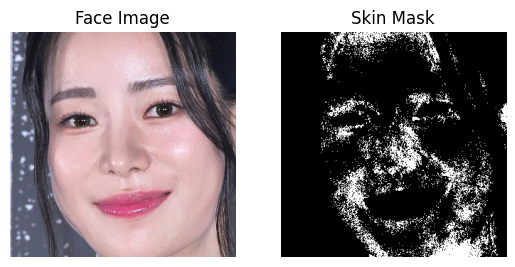

In [ ]:
# 피부 영역 마스킹 확인
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/drive/MyDrive/2GNVAS0ICV_1.jpg')
face_img = crop_face_opencv(img)  # 너가 만든 얼굴 크롭 함수

mask = skin_mask_hsv(face_img)

plt.subplot(1, 2, 1)
plt.title("Face Image")
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Skin Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()
